In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv('../data/train.csv', dtype={'tipodepropiedad':'category', 'ciudad':'category', 'provincia':'category', 'id':'int32', 'antiguedad':'float16', 'habitaciones':'float16', 'garages':'float16', 'banos':'float16', 'metroscubiertos':'float16', 'metrostotales':'float16', 'idzona':'float16', 'lat':'float16', 'lng':'float16', 'gimnasio':'bool', 'usosmultiples':'bool', 'piscina':'bool', 'escuelascercanas':'bool', 'centroscomercialescercanos':'bool'}, parse_dates=['fecha'])
test = pd.read_csv('../data/test.csv', dtype={'tipodepropiedad':'category', 'ciudad':'category', 'provincia':'category', 'id':'int32', 'antiguedad':'float16', 'habitaciones':'float16', 'garages':'float16', 'banos':'float16', 'metroscubiertos':'float16', 'metrostotales':'float16', 'idzona':'float16', 'lat':'float16', 'lng':'float16', 'gimnasio':'bool', 'usosmultiples':'bool', 'piscina':'bool', 'escuelascercanas':'bool', 'centroscomercialescercanos':'bool'}, parse_dates=['fecha'])

rescued_coords = pd.read_csv('../data/rescueLatLongs.csv')

def contar_amenities(row):
    return row['gimnasio'] + row['usosmultiples'] + row['piscina'] + row['escuelascercanas'] + row['centroscomercialescercanos']

train['cant_amenities'] = train.apply(lambda x: contar_amenities(x), axis=1)
test['cant_amenities'] = test.apply(lambda x: contar_amenities(x), axis=1)

def feature_fechas(df):
    # Para entender lo de los senos y cosenos: https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
    df['year'] = df['fecha'].dt.year
    df['month'] = df['fecha'].dt.month
    df['day'] = df['fecha'].dt.day
    df['sin_month'] = np.sin(2*np.pi*df['month']/12)
    df['cos_month'] = np.cos(2*np.pi*df['month']/12)
    # tomo cant. de dias en mes: 31 en todos los casos. Para esto deberia servir bastante bien igual.
    df['sin_day'] = np.sin(2*np.pi*df['day']/31)
    df['cos_day'] = np.cos(2*np.pi*df['day']/31)
    
    df['dayofweek'] = df['fecha'].dt.dayofweek
    df['sin_dayofweek'] = np.sin(2*np.pi*df['dayofweek']/7)
    df['cos_dayofweek'] = np.cos(2*np.pi*df['dayofweek']/7)
    
    df['dayofyear'] = df['fecha'].dt.dayofyear
    df['sin_dayofyear'] = np.sin(2*np.pi*df['dayofyear']/365)
    df['cos_dayofyear'] = np.cos(2*np.pi*df['dayofyear']/365)
    
    
#     df['days_in_month'] = df['fecha'].dt.days_in_month
    df['daysinmonth'] = df['fecha'].dt.daysinmonth
    df['is_leap_year'] = df['fecha'].dt.is_leap_year
    df['is_month_end'] = df['fecha'].dt.is_month_end
    df['is_month_start'] = df['fecha'].dt.is_month_start
    df['is_quarter_end'] = df['fecha'].dt.is_quarter_end
    df['is_quarter_start'] = df['fecha'].dt.is_quarter_start
    df['is_year_end'] = df['fecha'].dt.is_year_end
    df['is_year_start'] = df['fecha'].dt.is_year_start
    
#     df['week'] = df['fecha'].dt.week
    df['weekofyear'] = df['fecha'].dt.weekofyear
    df['sin_weekofyear'] = np.sin(2*np.pi*df['weekofyear']/53)
    df['cos_weekofyear'] = np.cos(2*np.pi*df['weekofyear']/53)
    
    # no necesito mas las cols. originales de month y day.
    df.drop(['month','day','dayofweek','dayofyear','weekofyear'], axis=1, inplace=True)
    
feature_fechas(train)
feature_fechas(test)

import itertools
def two_set_bools(df, bool_features):
    for combination in itertools.combinations(bool_features,2):
        if combination[0] != combination[1]:
            new_feature_name = combination[0] + "_AND_" + combination[1]
            df[new_feature_name] = df[combination[0]] & df[combination[1]]
            
            new_feature_name = combination[0] + "_OR_" + combination[1]
            df[new_feature_name] = df[combination[0]] | df[combination[1]]
            
            new_feature_name = combination[0] + "_XOR_" + combination[1]
            df[new_feature_name] = df[combination[0]] ^ df[combination[1]]

two_set_bools(train, ['gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos'])
two_set_bools(test, ['gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos'])

train['reatio_cubiertos_totales'] = train['metroscubiertos']/train['metrostotales']
test['reatio_cubiertos_totales'] = test['metroscubiertos']/train['metrostotales']

palabras_avenida = ['avenida', 'av']
train['es_avenida'] = train['direccion'].fillna('no info').apply(lambda x: any(avenida_indicator in x.lower() for avenida_indicator in palabras_avenida))
test['es_avenida'] = test['direccion'].fillna('no info').apply(lambda x: any(avenida_indicator in x.lower() for avenida_indicator in palabras_avenida))

train['titulo'].fillna("", inplace=True)

train['titulo_cant_html_tags'] = train['titulo'].apply(lambda x: len(x.split('<'))-1)

test['titulo'].fillna("", inplace=True)

test['titulo_cant_html_tags'] = test['titulo'].apply(lambda x: len(x.split('<'))-1)

train['titulo_cant_palabras'] = train['titulo'].apply(lambda x: len(x.split()))

test['titulo_cant_palabras'] = test['titulo'].apply(lambda x: len(x.split()))

train['titulo_cant_palabras_unicas'] = train['titulo'].apply(lambda x: len(set(x.split())))

test['titulo_cant_palabras_unicas'] = test['titulo'].apply(lambda x: len(set(x.split())))

# Concepto traido de https://docs.featuretools.com/generated/nlp_primitives.DiversityScore.html#nlp_primitives.DiversityScore
# Cito de la doc oficial:
#         Given a list of strings, calculates the total number of unique words divided by the total number of words
#         in order to give the text a score from 0-1 that indicates how unique the words used in it are.

train['titulo_diversity_score'] = train['titulo_cant_palabras_unicas']/train['titulo_cant_palabras']

test['titulo_diversity_score'] = test['titulo_cant_palabras_unicas']/test['titulo_cant_palabras']

train['titulo_cant_caracteres'] = train['titulo'].apply(lambda x: len(x))

test['titulo_cant_caracteres'] = test['titulo'].apply(lambda x: len(x))

import re
train['titulo_cant_signos_puntuacion'] = train['titulo'].apply(lambda x: len(re.split("['.', ',', '!', '?', '¿', '¡', '-']",x)))

test['titulo_cant_signos_puntuacion'] = test['titulo'].apply(lambda x: len(re.split("['.', ',', '!', '?', '¿', '¡', '-']",x)))

# source: https://stackoverflow.com/a/2979208
import math

def entropy(string):
        "Calculates the Shannon entropy of a string"

        # get probability of chars in string
        prob = [ float(string.count(c)) / len(string) for c in dict.fromkeys(list(string)) ]

        # calculate the entropy
        entropy = - sum([ p * math.log(p) / math.log(2.0) for p in prob ])

        return entropy

train['titulo_entropy'] = train['titulo'].apply(lambda x: entropy(x))

test['titulo_entropy'] = test['titulo'].apply(lambda x: entropy(x))

train['titulo_mean_word_length'] = train['titulo'].apply(lambda x: np.mean([len(word) for word in x.split()] if x.split() else np.nan))

test['titulo_mean_word_length'] = test['titulo'].apply(lambda x: np.mean([len(word) for word in x.split()] if x.split() else np.nan))

train['descripcion'].fillna("", inplace=True)

train['descripcion_cant_html_tags'] = train['descripcion'].apply(lambda x: len(x.split('<'))-1)

test['descripcion'].fillna("", inplace=True)

test['descripcion_cant_html_tags'] = test['descripcion'].apply(lambda x: len(x.split('<'))-1)

train['descripcion_cant_palabras'] = train['descripcion'].apply(lambda x: len(x.split()))

test['descripcion_cant_palabras'] = test['descripcion'].apply(lambda x: len(x.split()))

train['descripcion_cant_palabras_unicas'] = train['descripcion'].apply(lambda x: len(set(x.split())))

test['descripcion_cant_palabras_unicas'] = test['descripcion'].apply(lambda x: len(set(x.split())))

# Concepto traido de https://docs.featuretools.com/generated/nlp_primitives.DiversityScore.html#nlp_primitives.DiversityScore
# Cito de la doc oficial:
#         Given a list of strings, calculates the total number of unique words divided by the total number of words
#         in order to give the text a score from 0-1 that indicates how unique the words used in it are.

train['descripcion_diversity_score'] = train['descripcion_cant_palabras_unicas']/train['descripcion_cant_palabras']

test['descripcion_diversity_score'] = test['descripcion_cant_palabras_unicas']/test['descripcion_cant_palabras']

train['descripcion_cant_caracteres'] = train['descripcion'].apply(lambda x: len(x))

test['descripcion_cant_caracteres'] = test['descripcion'].apply(lambda x: len(x))

import re
train['descripcion_cant_signos_puntuacion'] = train['descripcion'].apply(lambda x: len(re.split("['.', ',', '!', '?', '¿', '¡', '-']",x)))

test['descripcion_cant_signos_puntuacion'] = test['descripcion'].apply(lambda x: len(re.split("['.', ',', '!', '?', '¿', '¡', '-']",x)))

# source: https://stackoverflow.com/a/2979208
import math

def entropy(string):
        "Calculates the Shannon entropy of a string"

        # get probability of chars in string
        prob = [ float(string.count(c)) / len(string) for c in dict.fromkeys(list(string)) ]

        # calculate the entropy
        entropy = - sum([ p * math.log(p) / math.log(2.0) for p in prob ])

        return entropy

train['descripcion_entropy'] = train['descripcion'].apply(lambda x: entropy(x))

test['descripcion_entropy'] = test['descripcion'].apply(lambda x: entropy(x))

train['descripcion_mean_word_length'] = train['descripcion'].apply(lambda x: np.mean([len(word) for word in x.split()] if x.split() else np.nan))

test['descripcion_mean_word_length'] = test['descripcion'].apply(lambda x: np.mean([len(word) for word in x.split()] if x.split() else np.nan))

del rescued_coords

In [2]:
# Define a seed, so all algorithms that accept a seed, take the same, for consistency reasons,
# so everything can be replicated without problems random state
seed=42

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train.drop('precio', axis=1), train['precio'], test_size=0.33, random_state=seed)

In [4]:
# To save predictions.
# There must be a directory ../predictions for this to work as expected.
# source: https://gist.github.com/rozanecm/ee8333741db42b10158b3e0aff3f22aa
import time
def _get_filename(my_name, timestamp):
    return "../predictions/" + timestamp + " by " + my_name + ".csv"

def _save_description(authors_name, timestamp, submission_description):
    f = open("../predictions/" + authors_name + ".txt","a")
    f.write(timestamp + ": " + submission_description + '\n')
    f.close()

def save_submission(submission_df, authors_name="rozanecm", description = "no description.", index=False, header=True):
    timestamp = time.strftime("%Y.%m.%d - %H:%M:%S")
    submission_df.to_csv(_get_filename(authors_name, timestamp), index=index, header=header)
    _save_description(authors_name, timestamp, description)

# Approach 1: LightGBM with grid search (pero el anterior, no uno nuevo!)

In [5]:
import lightgbm as lgb
gbm_optimized = lgb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=75,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=1200, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [8]:
gbm_optimized.fit(X_train.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y_train, sample_weight=None, init_score=None, eval_set=[(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1),y_test)], eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=10,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)

y_scores = gbm_optimized.predict(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), num_iteration=gbm_optimized.best_iteration_)

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


543916.1495199973


## Entrenamiento con todos los datos para obtener predicciones a subir

In [9]:
gbm_optimized.fit(train.drop(['id','fecha','titulo', 'descripcion', 'direccion','precio'],axis=1), train['precio'], sample_weight=None, init_score=None, eval_set=None, eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=None,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)


# prediciendo valores posta...
predictions = gbm_optimized.predict(test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), num_iteration=gbm_optimized.best_iteration_)

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [10]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [14]:
description = "1st approach with feat. eng.. LightGBM with grid search."
save_submission(df, description=description)

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [9]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_1_with_feat_eng"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['fecha','titulo', 'descripcion', 'direccion', 'precio'],axis=1).iloc[train_index], train.drop(['fecha','titulo', 'descripcion', 'direccion', 'precio'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio'][train_index], train['precio'][test_index]
    
    gbm_optimized.fit(X_train2.drop(['id'],axis=1), y_train2, sample_weight=None, init_score=None, eval_set=None, eval_names=None,
                      eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=None,
                      verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)
    y_scores = gbm_optimized.predict(X_test2.drop('id',axis=1), num_iteration=gbm_optimized.best_iteration_)
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


542962.3400093812


/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


547436.3113737062


/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


544161.1319283972


# Approach 2

In [3]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
gbm = lgb.LGBMRegressor(silent=False)

param_dist = {"max_depth": [25,50, 75],
#               "learning_rate" : [0.01,0.05,0.1],
              "num_leaves": [300,900,1200],
#               "n_estimators": [100,200,300]
             }

grid_search = GridSearchCV(gbm, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="neg_mean_absolute_error", verbose=5)
grid_search.fit(train.drop(['id','fecha','titulo', 'descripcion', 'direccion','precio'],axis=1), train['precio'])
grid_search.best_estimator_

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 11.3min finished


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=75,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=1200, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=False,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [13]:
gbm_optimized = lgb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=75,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=1200, objective=None,
              random_state=seed, reg_alpha=0.0, reg_lambda=0.0, silent=False,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
gbm_optimized.fit(X_train.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y_train, sample_weight=None, init_score=None, eval_set=[(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1),y_test)], eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=10,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)

y_scores = gbm_optimized.predict(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1)
#                                  , num_iteration=gbm_optimized.best_iteration_
                                )

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

## Entrenamiento con todos los datos para obtener predicciones a subir

In [10]:
gbm_optimized.fit(train.drop(['id','fecha','titulo', 'descripcion', 'direccion','precio'],axis=1), train['precio'], sample_weight=None, init_score=None, eval_set=None, eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=None,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)


# prediciendo valores posta...
predictions = gbm_optimized.predict(test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), num_iteration=gbm_optimized.best_iteration_)

In [11]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [12]:
description = "2nd approach with feat. eng. catboost with grid search."
save_submission(df, description=description)

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [14]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_2_with_feat_eng"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['fecha','titulo', 'descripcion', 'direccion', 'precio'],axis=1).iloc[train_index], train.drop(['fecha','titulo', 'descripcion', 'direccion', 'precio'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio'][train_index], train['precio'][test_index]
    
    gbm_optimized.fit(X_train2.drop(['id'],axis=1), y_train2, sample_weight=None, init_score=None, eval_set=None, eval_names=None,
                      eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=None,
                      verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)
    y_scores = gbm_optimized.predict(X_test2.drop('id',axis=1), num_iteration=gbm_optimized.best_iteration_)
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

539510.8266631352


/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


544054.9531649371


/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


540778.0632067826


# Approach 3: LigthGBM with grid search

In [31]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
gbm = lgb.LGBMRegressor(n_jobs=-1,silent=False, random_state=seed)

param_dist = {'boosting_type':['gbdt','dart'],
              'num_leaves':[10],
              'max_depth':[4],
              'learning_rate':[0.05,0.15],
              'n_estimators':[200,300],
              'subsample':[0.8,1.0],
              'subsample_freq':[1],
              "num_leaves": [300,900,1200],
              'colsample_bytree':[0.8,1.0],}

# param_dist = {"max_depth": [25,50, 75],
#               "learning_rate" : [0.01,0.05,0.1],
#               "num_leaves": [300,900,1200],
#               "n_estimators": [50,100,200]
#              }

grid_search = GridSearchCV(gbm, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="neg_mean_absolute_error", verbose=5)
grid_search.fit(train.drop(['id','fecha','titulo', 'descripcion', 'direccion','precio'],axis=1), train['precio'])
print(grid_search.best_estimator_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.2min
/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 61.7min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 64.7min finished


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.15, max_depth=4,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=300, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=False,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=1)


In [18]:
gbm_optimized = lgb.LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=0.8,
              importance_type='split', learning_rate=0.05, max_depth=4,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=10, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=False,
              subsample=0.8, subsample_for_bin=200000, subsample_freq=1)

In [22]:
gbm_optimized = lgb.LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.15, max_depth=4,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=10, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=False,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=1)

In [29]:
gbm_optimized = lgb.LGBMRegressor(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.15, max_depth=4,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=300, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=False,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=1)

In [15]:
gbm_optimized = lgb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.15, max_depth=4,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=300, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=False,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=1)

In [33]:
gbm_optimized.fit(X_train.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), y_train, sample_weight=None, init_score=None, eval_set=[(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1),y_test)], eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=10,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)

y_scores = gbm_optimized.predict(X_test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), num_iteration=gbm_optimized.best_iteration_)

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


591294.1897764989


prev: 615

## Entrenamiento con todos los datos para obtener predicciones a subir

In [34]:
gbm_optimized.fit(train.drop(['id','fecha','titulo', 'descripcion', 'direccion','precio'],axis=1), train['precio'], sample_weight=None, init_score=None, eval_set=None, eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=None,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)


# prediciendo valores posta...
predictions = gbm_optimized.predict(test.drop(['id','fecha','titulo', 'descripcion', 'direccion'],axis=1), num_iteration=gbm_optimized.best_iteration_)

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [35]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [36]:
description = "3rd approach with feat. eng. LightGBM with grid search done locally, now done with all train set."
save_submission(df, description=description)

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [16]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_3_with_feat_eng"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train.drop(['fecha','titulo', 'descripcion', 'direccion', 'precio'],axis=1).iloc[train_index], train.drop(['fecha','titulo', 'descripcion', 'direccion', 'precio'],axis=1).iloc[test_index]
    y_train2, y_test2 = train['precio'][train_index], train['precio'][test_index]
    
    gbm_optimized.fit(X_train2.drop(['id'],axis=1), y_train2, sample_weight=None, init_score=None, eval_set=None, eval_names=None,
                      eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=None,
                      verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)
    y_scores = gbm_optimized.predict(X_test2.drop('id',axis=1), num_iteration=gbm_optimized.best_iteration_)
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


592524.9090233747


/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


596025.7391079679


/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


592995.6456958664


# Feature importance

Como el agregado de features no esta ayudando a mejorar el score, hagamos un estudio de feature importance.

In [8]:
import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import RandomForestRegressor

In [3]:
# inf. values don't make sense. I think it's preferable to treat them as nans directly.
train.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [29]:
rfr = RandomForestRegressor(random_state=seed, n_estimators=100)
rfr.fit(train.drop(['id','fecha','titulo', 'descripcion', 'direccion','tipodepropiedad','ciudad','provincia','precio'],axis=1).replace([np.nan], 0), train['precio'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [30]:
df_feat_importance = pd.DataFrame(data={'feat_name':train.drop(['id','fecha','titulo', 'descripcion', 'direccion','tipodepropiedad','ciudad','provincia','precio'],axis=1).columns,'feat_importance':rfr.feature_importances_}).sort_values('feat_importance', ascending=False).reset_index(drop=True)

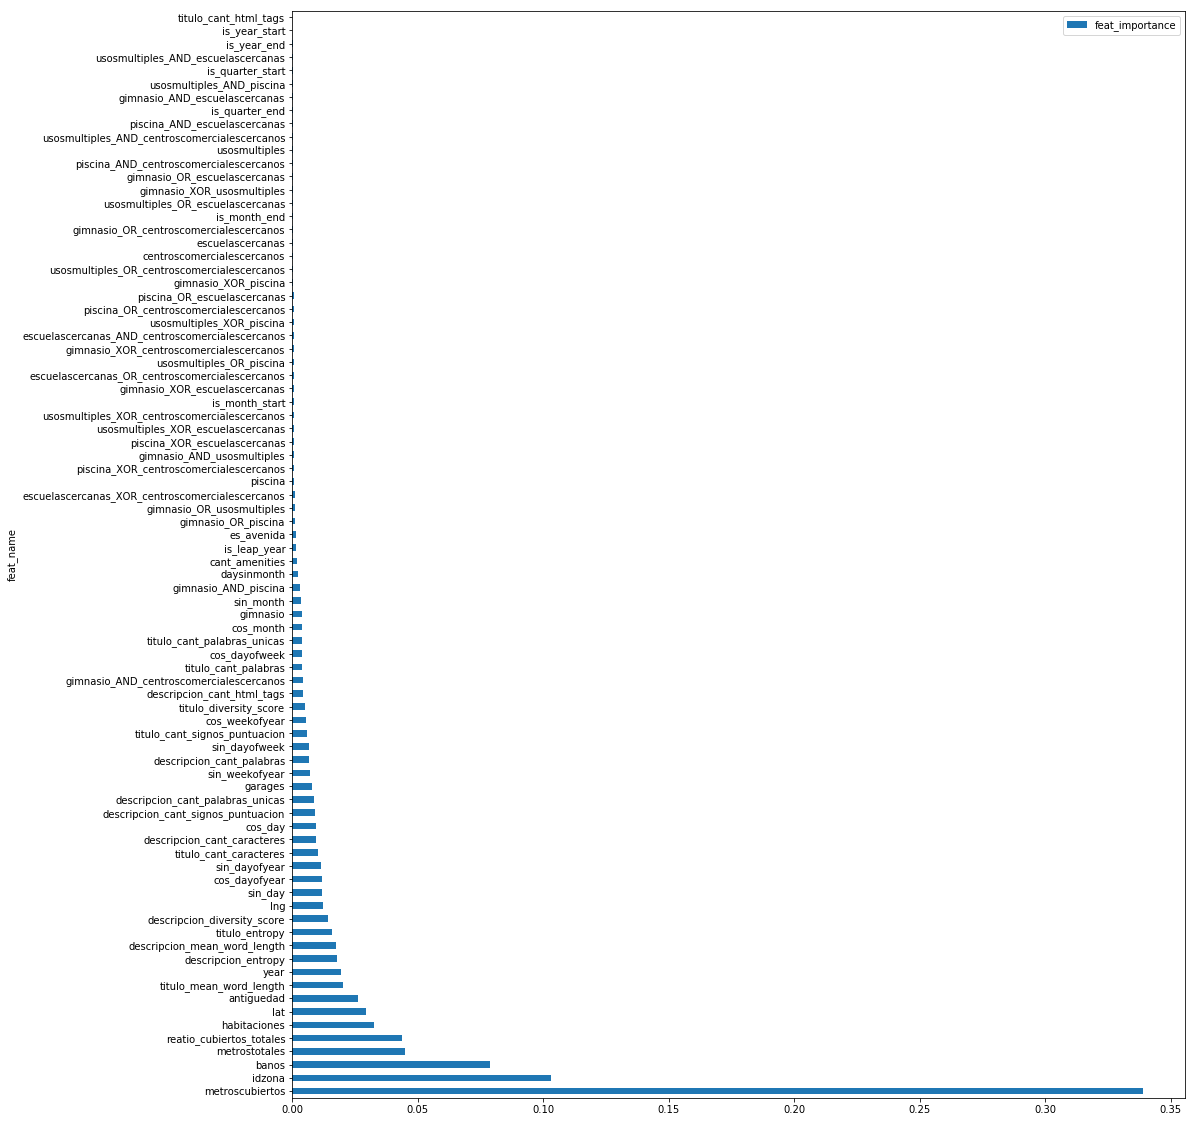

In [31]:
df_feat_importance.plot(x='feat_name',y='feat_importance',kind='barh', figsize=(16,20));

In [32]:
df_feat_importance.loc[df_feat_importance['feat_name'] == 'cant_amenities']

,feat_importance,feat_name
40,0.001685,cant_amenities


In [38]:
df_feat_importance.iloc[:41]['feat_name'].values

array(['metroscubiertos', 'idzona', 'banos', 'metrostotales',
       'reatio_cubiertos_totales', 'habitaciones', 'lat', 'antiguedad',
       'titulo_mean_word_length', 'year', 'descripcion_entropy',
       'descripcion_mean_word_length', 'titulo_entropy',
       'descripcion_diversity_score', 'lng', 'sin_day', 'cos_dayofyear',
       'sin_dayofyear', 'titulo_cant_caracteres',
       'descripcion_cant_caracteres', 'cos_day',
       'descripcion_cant_signos_puntuacion',
       'descripcion_cant_palabras_unicas', 'garages', 'sin_weekofyear',
       'descripcion_cant_palabras', 'sin_dayofweek',
       'titulo_cant_signos_puntuacion', 'cos_weekofyear',
       'titulo_diversity_score', 'descripcion_cant_html_tags',
       'gimnasio_AND_centroscomercialescercanos', 'titulo_cant_palabras',
       'cos_dayofweek', 'titulo_cant_palabras_unicas', 'cos_month',
       'gimnasio', 'sin_month', 'gimnasio_AND_piscina', 'daysinmonth',
       'cant_amenities'], dtype=object)

# Approach 4: LigthGBM with grid search after obtaining most important features.

In [46]:
train2 = train[['metroscubiertos', 'idzona', 'banos', 'metrostotales',
       'reatio_cubiertos_totales', 'habitaciones', 'lat', 'antiguedad',
       'titulo_mean_word_length', 'year', 'descripcion_entropy',
       'descripcion_mean_word_length', 'titulo_entropy',
       'descripcion_diversity_score', 'lng', 'sin_day', 'cos_dayofyear',
       'sin_dayofyear', 'titulo_cant_caracteres',
       'descripcion_cant_caracteres', 'cos_day',
       'descripcion_cant_signos_puntuacion',
       'descripcion_cant_palabras_unicas', 'garages', 'sin_weekofyear',
       'descripcion_cant_palabras', 'sin_dayofweek',
       'titulo_cant_signos_puntuacion', 'cos_weekofyear',
       'titulo_diversity_score', 'descripcion_cant_html_tags',
       'gimnasio_AND_centroscomercialescercanos', 'titulo_cant_palabras',
       'cos_dayofweek', 'titulo_cant_palabras_unicas', 'cos_month',
       'gimnasio', 'sin_month', 'gimnasio_AND_piscina', 'daysinmonth',
       'cant_amenities','precio']]
test2 = test[['metroscubiertos', 'idzona', 'banos', 'metrostotales',
       'reatio_cubiertos_totales', 'habitaciones', 'lat', 'antiguedad',
       'titulo_mean_word_length', 'year', 'descripcion_entropy',
       'descripcion_mean_word_length', 'titulo_entropy',
       'descripcion_diversity_score', 'lng', 'sin_day', 'cos_dayofyear',
       'sin_dayofyear', 'titulo_cant_caracteres',
       'descripcion_cant_caracteres', 'cos_day',
       'descripcion_cant_signos_puntuacion',
       'descripcion_cant_palabras_unicas', 'garages', 'sin_weekofyear',
       'descripcion_cant_palabras', 'sin_dayofweek',
       'titulo_cant_signos_puntuacion', 'cos_weekofyear',
       'titulo_diversity_score', 'descripcion_cant_html_tags',
       'gimnasio_AND_centroscomercialescercanos', 'titulo_cant_palabras',
       'cos_dayofweek', 'titulo_cant_palabras_unicas', 'cos_month',
       'gimnasio', 'sin_month', 'gimnasio_AND_piscina', 'daysinmonth',
       'cant_amenities']]

In [55]:
X_train2 = X_train[['metroscubiertos', 'idzona', 'banos', 'metrostotales',
       'reatio_cubiertos_totales', 'habitaciones', 'lat', 'antiguedad',
       'titulo_mean_word_length', 'year', 'descripcion_entropy',
       'descripcion_mean_word_length', 'titulo_entropy',
       'descripcion_diversity_score', 'lng', 'sin_day', 'cos_dayofyear',
       'sin_dayofyear', 'titulo_cant_caracteres',
       'descripcion_cant_caracteres', 'cos_day',
       'descripcion_cant_signos_puntuacion',
       'descripcion_cant_palabras_unicas', 'garages', 'sin_weekofyear',
       'descripcion_cant_palabras', 'sin_dayofweek',
       'titulo_cant_signos_puntuacion', 'cos_weekofyear',
       'titulo_diversity_score', 'descripcion_cant_html_tags',
       'gimnasio_AND_centroscomercialescercanos', 'titulo_cant_palabras',
       'cos_dayofweek', 'titulo_cant_palabras_unicas', 'cos_month',
       'gimnasio', 'sin_month', 'gimnasio_AND_piscina', 'daysinmonth',
       'cant_amenities','tipodepropiedad', 'ciudad','provincia']]
X_test2 = X_test[['metroscubiertos', 'idzona', 'banos', 'metrostotales',
       'reatio_cubiertos_totales', 'habitaciones', 'lat', 'antiguedad',
       'titulo_mean_word_length', 'year', 'descripcion_entropy',
       'descripcion_mean_word_length', 'titulo_entropy',
       'descripcion_diversity_score', 'lng', 'sin_day', 'cos_dayofyear',
       'sin_dayofyear', 'titulo_cant_caracteres',
       'descripcion_cant_caracteres', 'cos_day',
       'descripcion_cant_signos_puntuacion',
       'descripcion_cant_palabras_unicas', 'garages', 'sin_weekofyear',
       'descripcion_cant_palabras', 'sin_dayofweek',
       'titulo_cant_signos_puntuacion', 'cos_weekofyear',
       'titulo_diversity_score', 'descripcion_cant_html_tags',
       'gimnasio_AND_centroscomercialescercanos', 'titulo_cant_palabras',
       'cos_dayofweek', 'titulo_cant_palabras_unicas', 'cos_month',
       'gimnasio', 'sin_month', 'gimnasio_AND_piscina', 'daysinmonth',
       'cant_amenities','tipodepropiedad', 'ciudad','provincia']]

In [47]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
gbm = lgb.LGBMRegressor(n_jobs=-1,silent=False, random_state=seed)

param_dist = {'boosting_type':['gbdt','dart'],
              'num_leaves':[10],
              'max_depth':[4],
              'learning_rate':[0.05,0.15],
              'n_estimators':[200,300],
              'subsample':[0.8,1.0],
              "num_leaves": [300,900,1200],
              'colsample_bytree':[0.8,1.0],}

# param_dist = {"max_depth": [25,50, 75],
#               "learning_rate" : [0.01,0.05,0.1],
#               "num_leaves": [300,900,1200],
#               "n_estimators": [50,100,200]
#              }

grid_search = GridSearchCV(gbm, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="neg_mean_absolute_error", verbose=5)
grid_search.fit(train2.drop(['precio'],axis=1), train2['precio'])
print(grid_search.best_estimator_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   54.4s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 48.9min
[Parallel(n_jobs=-1)]: Done 288 out of 288 | elapsed: 51.2min finished


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.15, max_depth=4,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=300, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=False,
              subsample=0.8, subsample_for_bin=200000, subsample_freq=0)


In [17]:
gbm_optimized = lgb.LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.15, max_depth=4,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=300, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=False,
              subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

In [56]:
gbm_optimized.fit(X_train2, y_train, sample_weight=None, init_score=None, eval_set=[(X_test2,y_test)], eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=10,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)

y_scores = gbm_optimized.predict(X_test2, num_iteration=gbm_optimized.best_iteration_)

from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_scores))

/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


589524.4024022974


## Entrenamiento con todos los datos para obtener predicciones a subir

In [19]:
train2 = train[['metroscubiertos', 'idzona', 'banos', 'metrostotales',
       'reatio_cubiertos_totales', 'habitaciones', 'lat', 'antiguedad',
       'titulo_mean_word_length', 'year', 'descripcion_entropy',
       'descripcion_mean_word_length', 'titulo_entropy',
       'descripcion_diversity_score', 'lng', 'sin_day', 'cos_dayofyear',
       'sin_dayofyear', 'titulo_cant_caracteres',
       'descripcion_cant_caracteres', 'cos_day',
       'descripcion_cant_signos_puntuacion',
       'descripcion_cant_palabras_unicas', 'garages', 'sin_weekofyear',
       'descripcion_cant_palabras', 'sin_dayofweek',
       'titulo_cant_signos_puntuacion', 'cos_weekofyear',
       'titulo_diversity_score', 'descripcion_cant_html_tags',
       'gimnasio_AND_centroscomercialescercanos', 'titulo_cant_palabras',
       'cos_dayofweek', 'titulo_cant_palabras_unicas', 'cos_month',
       'gimnasio', 'sin_month', 'gimnasio_AND_piscina', 'daysinmonth',
       'cant_amenities','precio','tipodepropiedad', 'ciudad','provincia']]
test2 = test[['metroscubiertos', 'idzona', 'banos', 'metrostotales',
       'reatio_cubiertos_totales', 'habitaciones', 'lat', 'antiguedad',
       'titulo_mean_word_length', 'year', 'descripcion_entropy',
       'descripcion_mean_word_length', 'titulo_entropy',
       'descripcion_diversity_score', 'lng', 'sin_day', 'cos_dayofyear',
       'sin_dayofyear', 'titulo_cant_caracteres',
       'descripcion_cant_caracteres', 'cos_day',
       'descripcion_cant_signos_puntuacion',
       'descripcion_cant_palabras_unicas', 'garages', 'sin_weekofyear',
       'descripcion_cant_palabras', 'sin_dayofweek',
       'titulo_cant_signos_puntuacion', 'cos_weekofyear',
       'titulo_diversity_score', 'descripcion_cant_html_tags',
       'gimnasio_AND_centroscomercialescercanos', 'titulo_cant_palabras',
       'cos_dayofweek', 'titulo_cant_palabras_unicas', 'cos_month',
       'gimnasio', 'sin_month', 'gimnasio_AND_piscina', 'daysinmonth',
       'cant_amenities','tipodepropiedad', 'ciudad','provincia']]

In [61]:
gbm_optimized.fit(train2.drop('precio',axis=1), train['precio'], sample_weight=None, init_score=None, eval_set=None, eval_names=None,
            eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=None,
            verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)


# prediciendo valores posta...
predictions = gbm_optimized.predict(test2, num_iteration=gbm_optimized.best_iteration_)

In [62]:
df = pd.DataFrame(data={'id':test['id'], 'target':predictions})

In [63]:
description = "4th approach with feat. eng. and feature selection via random forest. LightGBM with grid search done locally."
save_submission(df, description=description)

## Obtengamos prediccionse para todas las propiedades en nuestro train set

In [22]:
train2 = train[['id', 'metroscubiertos', 'idzona', 'banos', 'metrostotales',
       'reatio_cubiertos_totales', 'habitaciones', 'lat', 'antiguedad',
       'titulo_mean_word_length', 'year', 'descripcion_entropy',
       'descripcion_mean_word_length', 'titulo_entropy',
       'descripcion_diversity_score', 'lng', 'sin_day', 'cos_dayofyear',
       'sin_dayofyear', 'titulo_cant_caracteres',
       'descripcion_cant_caracteres', 'cos_day',
       'descripcion_cant_signos_puntuacion',
       'descripcion_cant_palabras_unicas', 'garages', 'sin_weekofyear',
       'descripcion_cant_palabras', 'sin_dayofweek',
       'titulo_cant_signos_puntuacion', 'cos_weekofyear',
       'titulo_diversity_score', 'descripcion_cant_html_tags',
       'gimnasio_AND_centroscomercialescercanos', 'titulo_cant_palabras',
       'cos_dayofweek', 'titulo_cant_palabras_unicas', 'cos_month',
       'gimnasio', 'sin_month', 'gimnasio_AND_piscina', 'daysinmonth',
       'cant_amenities','precio','tipodepropiedad', 'ciudad','provincia']]
test2 = test[['id', 'metroscubiertos', 'idzona', 'banos', 'metrostotales',
       'reatio_cubiertos_totales', 'habitaciones', 'lat', 'antiguedad',
       'titulo_mean_word_length', 'year', 'descripcion_entropy',
       'descripcion_mean_word_length', 'titulo_entropy',
       'descripcion_diversity_score', 'lng', 'sin_day', 'cos_dayofyear',
       'sin_dayofyear', 'titulo_cant_caracteres',
       'descripcion_cant_caracteres', 'cos_day',
       'descripcion_cant_signos_puntuacion',
       'descripcion_cant_palabras_unicas', 'garages', 'sin_weekofyear',
       'descripcion_cant_palabras', 'sin_dayofweek',
       'titulo_cant_signos_puntuacion', 'cos_weekofyear',
       'titulo_diversity_score', 'descripcion_cant_html_tags',
       'gimnasio_AND_centroscomercialescercanos', 'titulo_cant_palabras',
       'cos_dayofweek', 'titulo_cant_palabras_unicas', 'cos_month',
       'gimnasio', 'sin_month', 'gimnasio_AND_piscina', 'daysinmonth',
       'cant_amenities','tipodepropiedad', 'ciudad','provincia']]

In [24]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
kf = KFold(n_splits=3, shuffle=True, random_state=seed)

df = pd.DataFrame([])

# UPDATE THIS VALUE
approach_numer = "rozanecm_approach_4_with_feat_eng"

for train_index, test_index in kf.split(train):
    # for loop copied from docs: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold
    X_train2, X_test2 = train2.drop(['precio'],axis=1).iloc[train_index], train2.drop(['precio'],axis=1).iloc[test_index]
    y_train2, y_test2 = train2['precio'][train_index], train2['precio'][test_index]
    
    gbm_optimized.fit(X_train2.drop(['id'],axis=1), y_train2, sample_weight=None, init_score=None, eval_set=None, eval_names=None,
                      eval_sample_weight=None, eval_init_score=None, eval_metric='mae', early_stopping_rounds=None,
                      verbose=False, feature_name='auto', categorical_feature=['tipodepropiedad', 'ciudad','provincia'], callbacks=None)
    y_scores = gbm_optimized.predict(X_test2.drop('id',axis=1), num_iteration=gbm_optimized.best_iteration_)
    
    print(mean_absolute_error(y_test2, y_scores))
    
    df = df.append(pd.DataFrame(data={'id':X_test2['id'], approach_numer:y_scores}))

df.to_csv("../predictions/on_train_data/" + approach_numer, index=False, header=True)

591589.6330611027


/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


597007.1539011439


/home/rozanecm/Documents/Univerza/UBA/7506 Organizacion de Datos/2c2019/tp2/venv/lib/python3.5/site-packages/lightgbm/basic.py:1247: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ciudad', 'provincia', 'tipodepropiedad']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


592220.5932303993
